In [29]:
import numpy as np
from sklearn.feature_selection import f_regression
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

from utils import seed_everything
from utils import load_datasets
from pipeline import FedotPipeline

In [ ]:
!unzip Gd_fps.zip

In [2]:
SEED = 42

In [3]:
seed_everything(SEED)

In [4]:
datasets = load_datasets("")

In [5]:
fedot_kwargs = dict(
    problem='regression',
    timeout=5.0,
    n_jobs=-1,
    logging_level=50,
)

In [6]:
n_splits = 5

In [7]:
pipeline = FedotPipeline(
    datasets=datasets,
    target_col="lgK",
    results_dir='results',
    n_splits=n_splits,
    seed=SEED,
    var_threshold=0.01,
    fs_func=f_regression,
    k_percents=[None, 0.5, 0.75],
    fedot_kwargs=fedot_kwargs,
)

In [ ]:
all_results = pipeline.run()

In [9]:
all_results

{'Gd_ctopo_fp_cmplx': {'all': {'fs_func': 'f_regression',
   'k_percent': None,
   'results': {'cv_scores': {'0': {'rmse': 4.088284296973012,
      'r2': 0.13845542472076366,
      'mae': 3.04121982594485,
      'n_features': 267,
      'pipeline_path': 'results\\Gd_ctopo_fp_cmplx\\all_f_regression_fold_1.json'},
     '1': {'rmse': 3.9576698548197644,
      'r2': 0.0875312474075699,
      'mae': 3.2059168645504936,
      'n_features': 267,
      'pipeline_path': 'results\\Gd_ctopo_fp_cmplx\\all_f_regression_fold_2.json'},
     '2': {'rmse': 3.920190167859816,
      'r2': 0.33518520470307145,
      'mae': 3.112682977597862,
      'n_features': 267,
      'pipeline_path': 'results\\Gd_ctopo_fp_cmplx\\all_f_regression_fold_3.json'},
     '3': {'rmse': 3.631237303428919,
      'r2': 0.3564798532534945,
      'mae': 3.081655926146874,
      'n_features': 267,
      'pipeline_path': 'results\\Gd_ctopo_fp_cmplx\\all_f_regression_fold_4.json'},
     '4': {'rmse': 4.486644056356961,
      'r2':

In [30]:


with open("automl_results.json", "w") as f:
    json.dump(all_results, f, indent=4)

<Figure size 2000x600 with 0 Axes>

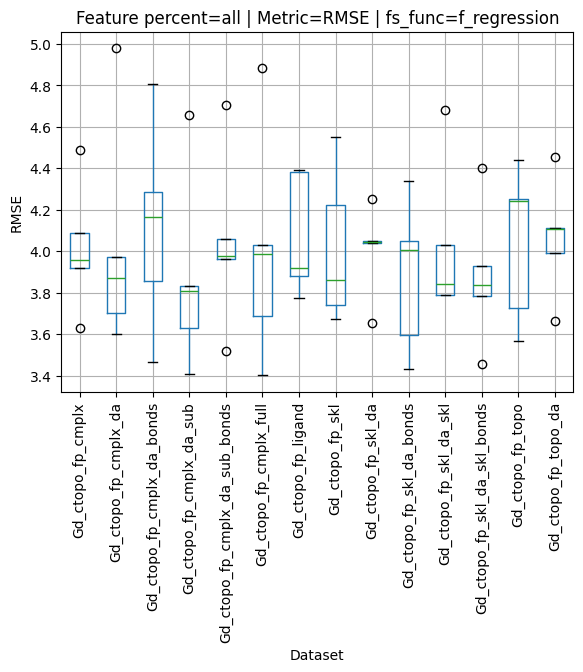

<Figure size 2000x600 with 0 Axes>

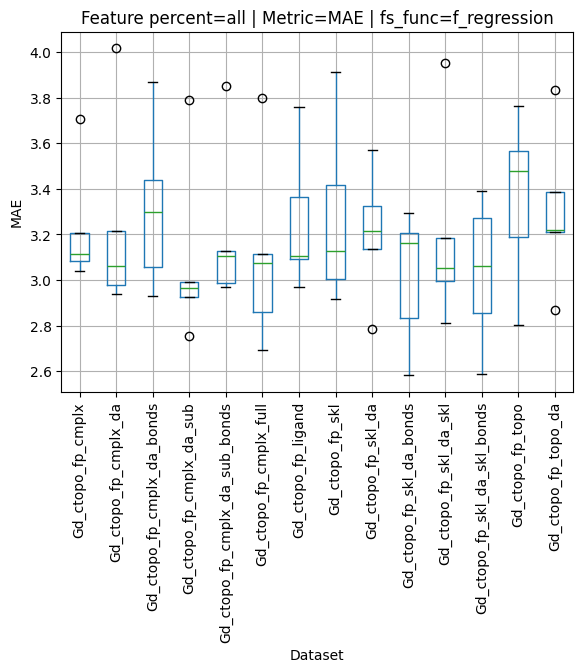

<Figure size 2000x600 with 0 Axes>

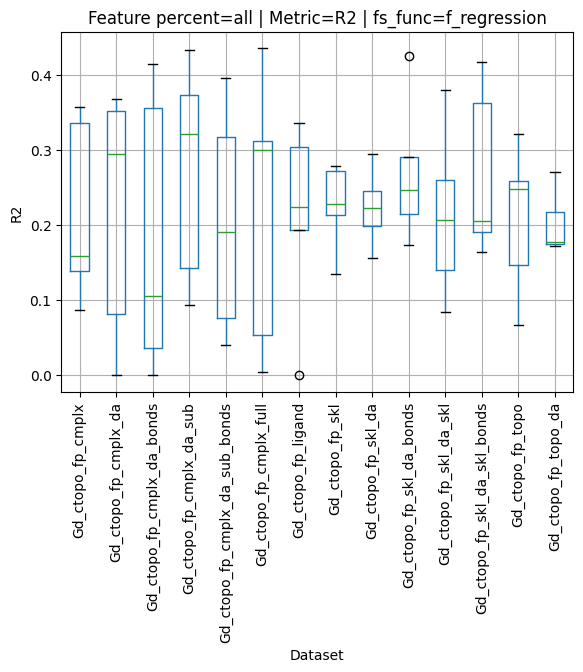

<Figure size 2000x600 with 0 Axes>

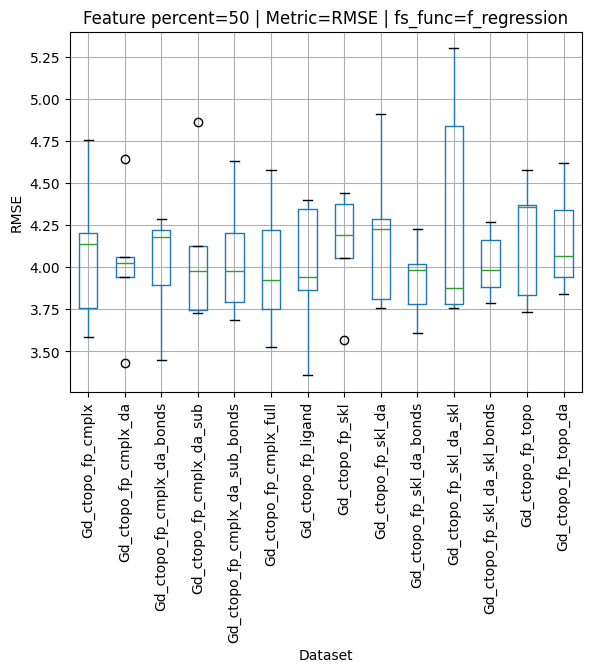

<Figure size 2000x600 with 0 Axes>

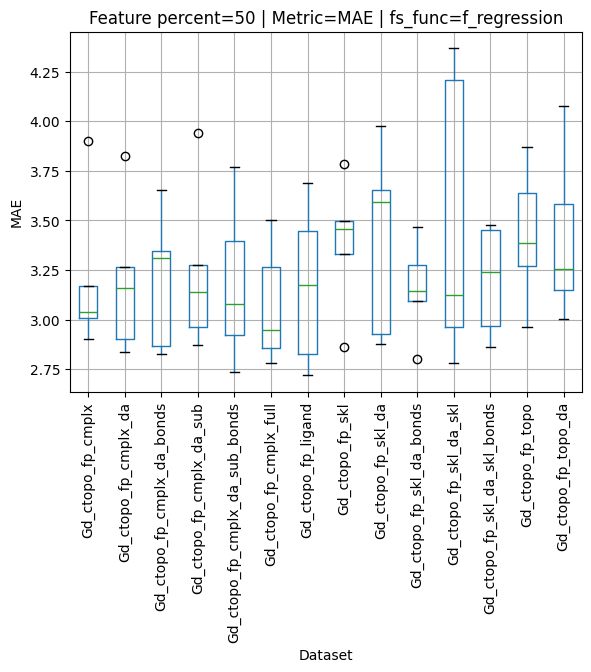

<Figure size 2000x600 with 0 Axes>

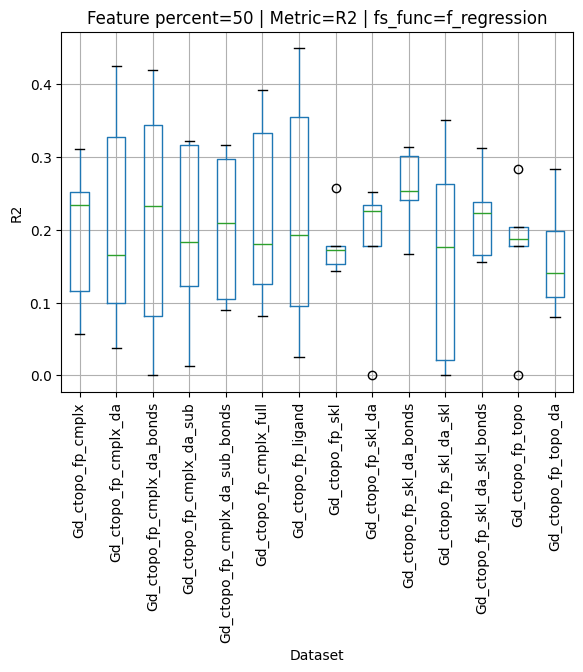

<Figure size 2000x600 with 0 Axes>

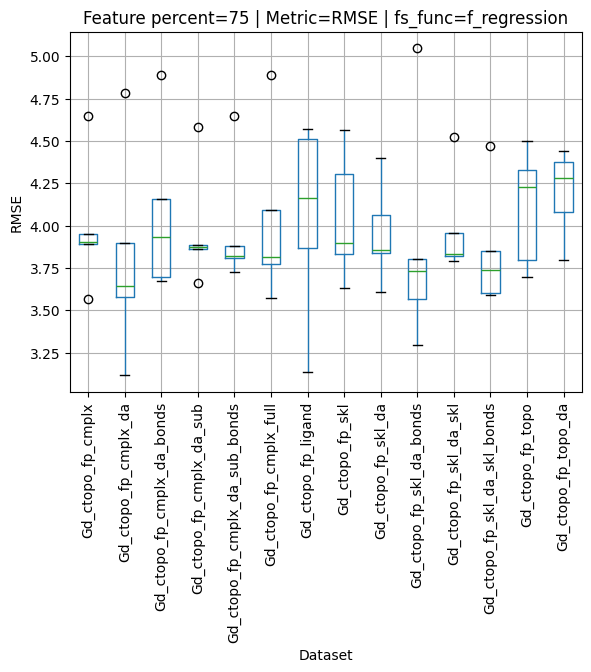

<Figure size 2000x600 with 0 Axes>

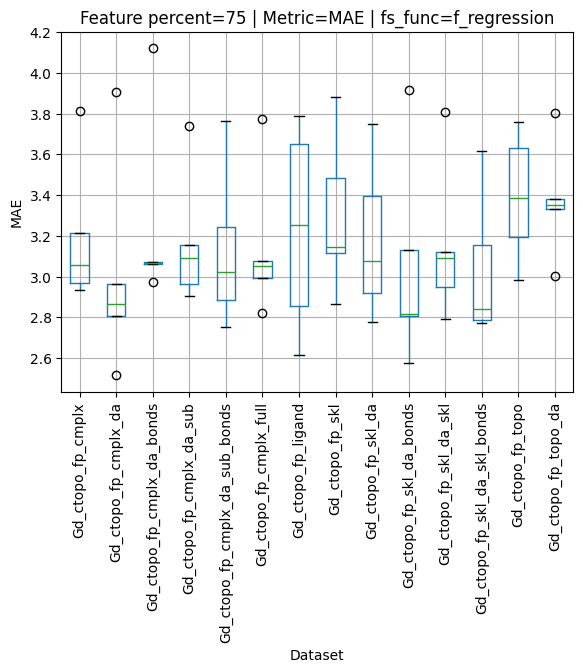

<Figure size 2000x600 with 0 Axes>

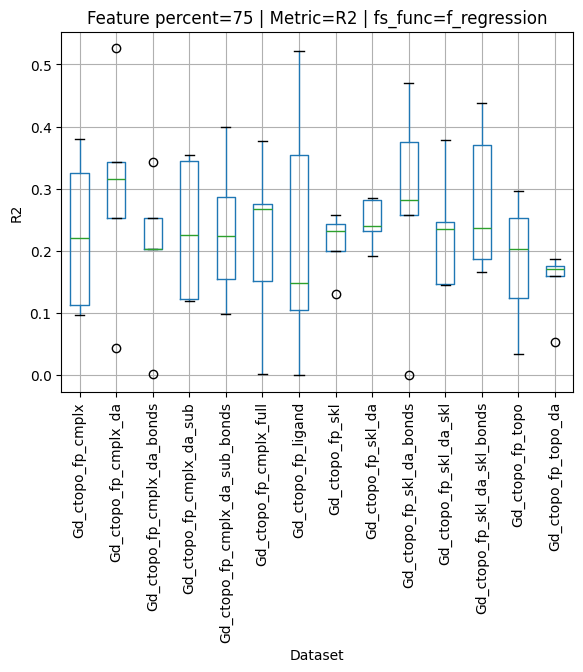

In [21]:
def plot_by_percent(data: dict):
    records = []
    for dataset, dataset_data in data.items():
        for k_percent, info in dataset_data.items():
            fs_func = info['fs_func']
            k_val = k_percent
            for fold, metrics in info['results']['cv_scores'].items():
                r2 = max(metrics['r2'], 0)
                records.append({
                    'dataset': dataset,
                    'k_percent': k_val,
                    'fold': fold,
                    'rmse': metrics['rmse'],
                    'r2': r2,
                    'mae': metrics['mae'],
                    'fs_func': fs_func
                })
    
    df = pd.DataFrame(records)

    for k_val in df['k_percent'].unique():
        subset = df[df['k_percent'] == k_val]
        fs_func = subset['fs_func'].iloc[0] if not subset.empty else "unknown"
        for metric in ['rmse', 'mae', 'r2']:
            plt.figure(figsize=(20, 6))
            subset.boxplot(column=metric, by="dataset")
            plt.title(f"Feature percent={k_val} | Metric={metric.upper()} | fs_func={fs_func}")
            plt.suptitle("")
            plt.xlabel("Dataset")
            plt.ylabel(metric.upper())
            plt.xticks(rotation=90)
            # plt.tight_layout()
            plt.show()

plot_by_percent(all_results)

In [ ]:
def build_pipeline_summary(results_data, base_path="results"):
    rows = []
    for dataset, dataset_data in results_data.items():
        for k_percent, info in dataset_data.items():
            fs_func = info['fs_func']
            res = info['results']
            
            # --- CV results, one row per fold ---
            cv_scores = res['cv_scores']
            for fold_id, metrics in cv_scores.items():
                # Parse pipeline JSON for this fold
                pipe_path = metrics['pipeline_path']
                if not os.path.exists(pipe_path):
                    print(f"Warning: missing pipeline file {pipe_path}")
                    continue
                with open(pipe_path, "r") as f:
                    pipeline = json.load(f)

                rows.append({
                    "dataset": dataset,
                    "features_percent": k_percent,
                    "fs_func": fs_func,
                    "pipeline_ops": pipeline.get("total_pipeline_operations", []),
                    "depth": pipeline.get("depth", None),
                    "fold": fold_id,
                    "stage": "cv",  # cross-validation
                    "rmse": metrics['rmse'],
                    "mae": metrics['mae'],
                    "r2": max(metrics['r2'], 0)
                })
            
            # --- Train/test row ---
            pipe_path = res['pipeline_path']
            if os.path.exists(pipe_path):
                with open(pipe_path, "r") as f:
                    pipeline = json.load(f)

                rows.append({
                    "dataset": dataset,
                    "features_percent": k_percent,
                    "fs_func": fs_func,
                    "pipeline_ops": pipeline.get("total_pipeline_operations", []),
                    "depth": pipeline.get("depth", None),
                    "fold": None,
                    "stage": "train_test",  # final evaluation
                    "rmse": res.get('test_rmse', None),
                    "mae": res.get('test_mae', None),
                    "r2": max(res.get('test_r2', 0), 0)
                })

    return pd.DataFrame(rows)

summary_df = build_pipeline_summary(all_results)

In [33]:
summary_df.to_csv("pipeline_summary.csv", index=False)

In [7]:
summary_df = pd.read_csv("pipeline_summary.csv")

In [10]:
train_test_df = summary_df[summary_df['stage'] == 'train_test']

In [14]:
with open("baseline_results.json", "r") as f:
    baseline_data = json.load(f)

In [25]:
baseline_records = []
for dataset, metrics in baseline_data.items():
    baseline_records.append({
        "dataset": dataset[:-4],  # remove .csv suffix
        "baseline_rmse": np.sqrt(metrics['holdout_metrics']['RMSE']),
        "baseline_mae": metrics['holdout_metrics']['MAE'],
        "baseline_r2": max(metrics['holdout_metrics']['R2'], 0)
    })
baseline_records = pd.DataFrame(baseline_records)

In [26]:
train_test_df = train_test_df.merge(baseline_records, on="dataset", how="left")

In [28]:
train_test_df.to_csv("results_comparison.csv", index=False)